# Comparison metrics

Because we cannot trust the human eyes to make comparison between pictures, especially if the eye is French and colorblind.

## Requirements

In [10]:
import os
import sys
import json
import random
from pathlib import Path
sys.path.insert(0, os.path.join("..", "..", "src"))

import torch
import pyvips
import deeplake
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse
from skimage import io, color, filters
from scipy.stats import pearsonr
from scipy.spatial.distance import cosine
import cv2
import seaborn as sns

Functions to migrate image appearance

In [7]:
def low_freq_mutate_np( amp_src, amp_trg, L=0.1 ):
    a_src = np.fft.fftshift( amp_src, axes=(-2, -1) )
    a_trg = np.fft.fftshift( amp_trg, axes=(-2, -1) )

    _, h, w = a_src.shape
    b = (  np.floor(np.amin((h,w))*L)  ).astype(int)
    c_h = np.floor(h/2.0).astype(int)
    c_w = np.floor(w/2.0).astype(int)

    h1 = c_h-b
    h2 = c_h+b+1
    w1 = c_w-b
    w2 = c_w+b+1

    a_src[:,h1:h2,w1:w2] = a_trg[:,h1:h2,w1:w2]
    a_src = np.fft.ifftshift( a_src, axes=(-2, -1) )
    return a_src

def modif_FDA_source_to_target_np( src_img, amp_trg, L=0.1 ):
    fft_src_np = np.fft.fft2( src_img, axes=(-2, -1) )
    amp_src, pha_src = np.abs(fft_src_np), np.angle(fft_src_np)
    amp_src_ = low_freq_mutate_np( amp_src, amp_trg, L=L )
    fft_src_ = amp_src_ * np.exp( 1j * pha_src )
    src_in_trg = np.fft.ifft2( fft_src_, axes=(-2, -1) )
    src_in_trg = np.real(src_in_trg)

    return src_in_trg

def image_to_label(src_img, label, L_hyperparam=0.1):
    # computes the transformation of KBio images to the label-based amplitude
    trg_amp = np.load(f"/home/leolr-int/ASTAR_internship/Fourier_Domain_Adaptation/stored_amplitude/label_based_average/average_label_{label}_akoya.npy")
    return modif_FDA_source_to_target_np( src_img, trg_amp, L=L_hyperparam)

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse
from skimage import color, filters
from scipy.stats import pearsonr
from scipy.spatial.distance import cosine
import cv2
import seaborn as sns
import pandas as pd

def load_and_preprocess_image(img_array):
    """Load image from numpy array and convert to appropriate format"""
    img = img_array.copy()

    # Convert to grayscale if needed for some metrics
    if len(img.shape) == 3:
        img_gray = color.rgb2gray(img)
    else:
        img_gray = img

    # Normalize to [0, 1] range
    if img.max() > 1:
        img = img.astype(np.float64) / 255.0
        img_gray = img_gray.astype(np.float64) / 255.0

    return img, img_gray

def compute_similarity_metrics(original, comparison, original_gray, comparison_gray):
    """Compute various similarity metrics between two images"""
    metrics = {}

    # 1. Structural Similarity Index (SSIM)
    metrics['SSIM'] = ssim(original_gray, comparison_gray, data_range=1.0)
    print(f"SSIM: {metrics['SSIM']:.4f}")

    # 2. Peak Signal-to-Noise Ratio (PSNR)
    metrics['PSNR'] = psnr(original, comparison, data_range=1.0)

    # 3. Mean Squared Error (MSE)
    metrics['MSE'] = mse(original, comparison)

    # 4. Root Mean Squared Error (RMSE)
    metrics['RMSE'] = np.sqrt(metrics['MSE'])

    # 5. Mean Absolute Error (MAE)
    metrics['MAE'] = np.mean(np.abs(original - comparison))

    # 6. Normalized Cross-Correlation (NCC)
    original_flat = original_gray.flatten()
    comparison_flat = comparison_gray.flatten()
    correlation, _ = pearsonr(original_flat, comparison_flat)
    metrics['Correlation'] = correlation

    # 7. Cosine Similarity
    metrics['Cosine_Similarity'] = 1 - cosine(original_flat, comparison_flat)

    # 8. Histogram Intersection (for color images)
    if len(original.shape) == 3:
        original_uint8 = (original * 255).astype(np.uint8)
        comparison_uint8 = (comparison * 255).astype(np.uint8)
        hist_orig = cv2.calcHist([original_uint8], [0, 1, 2], None, [50, 50, 50], [0, 256, 0, 256, 0, 256])
        hist_comp = cv2.calcHist([comparison_uint8], [0, 1, 2], None, [50, 50, 50], [0, 256, 0, 256, 0, 256])
        metrics['Histogram_Intersection'] = cv2.compareHist(hist_orig, hist_comp, cv2.HISTCMP_INTERSECT)

    # 9. Edge-based similarity using Sobel filters
    edges_orig = filters.sobel(original_gray)
    edges_comp = filters.sobel(comparison_gray)
    edge_similarity = ssim(edges_orig, edges_comp, data_range=edges_orig.max() - edges_orig.min())
    metrics['Edge_SSIM'] = edge_similarity

    return metrics

def create_difference_visualizations(original, comparison, original_gray, comparison_gray, title):
    """Create various difference visualizations"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'Difference Analysis: {title}', fontsize=16)

    # Original image
    axes[0, 0].imshow(original, cmap='gray' if len(original.shape) == 2 else None)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')

    # Comparison image
    axes[0, 1].imshow(comparison, cmap='gray' if len(comparison.shape) == 2 else None)
    axes[0, 1].set_title('Comparison Image')
    axes[0, 1].axis('off')

    # Absolute difference
    abs_diff = np.abs(original_gray - comparison_gray)
    im1 = axes[0, 2].imshow(abs_diff, cmap='hot')
    axes[0, 2].set_title('Absolute Difference')
    axes[0, 2].axis('off')
    plt.colorbar(im1, ax=axes[0, 2])

    # Squared difference
    sq_diff = (original_gray - comparison_gray) ** 2
    im2 = axes[1, 0].imshow(sq_diff, cmap='hot')
    axes[1, 0].set_title('Squared Difference')
    axes[1, 0].axis('off')
    plt.colorbar(im2, ax=axes[1, 0])

    # Difference histogram
    diff_flat = (original_gray - comparison_gray).flatten()
    axes[1, 1].hist(diff_flat, bins=50, alpha=0.7, color='blue')
    axes[1, 1].set_title('Difference Histogram')
    axes[1, 1].set_xlabel('Pixel Difference')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].grid(True, alpha=0.3)

    # SSIM map
    ssim_map = ssim(original_gray, comparison_gray, data_range=1.0, full=True)[1]
    im3 = axes[1, 2].imshow(ssim_map, cmap='RdYlBu')
    axes[1, 2].set_title('SSIM Map')
    axes[1, 2].axis('off')
    plt.colorbar(im3, ax=axes[1, 2])

    plt.tight_layout()
    return fig

def analyze_images(original, comparison_paths, save_results=True):
    """Main function to analyze image similarities"""

    # Load original image
    original, original_gray = load_and_preprocess_image(original)
    print(f"Original image shape: {original.shape}")

    # Store all results
    all_metrics = {}

    # Compare each image with the original
    for i, comp_path in enumerate(comparison_paths):
        print(f"\nProcessing comparison image {i+1}")

        # Load comparison image
        comparison, comparison_gray = load_and_preprocess_image(comp_path)

        # Check if images have the same dimensions
        if original.shape != comparison.shape:
            print(f"Warning: Shape mismatch. Original: {original.shape}, Comparison: {comparison.shape}")
            # Resize comparison to match original
            if len(comparison.shape) == 3:
                comparison = cv2.resize(comparison, (original.shape[1], original.shape[0]))
            comparison_gray = cv2.resize(comparison_gray, (original.shape[1], original.shape[0]))

        # Compute metrics
        metrics = compute_similarity_metrics(original, comparison, original_gray, comparison_gray)
        all_metrics[f'Image_{i+1}'] = metrics

        # Create visualizations
        fig = create_difference_visualizations(original, comparison, original_gray, comparison_gray, f'Image {i+1}')

        if save_results:
            fig.savefig(f'comparison_image_{i+1}.png', dpi=300, bbox_inches='tight')

        plt.show()

    # Create summary comparison
    create_summary_comparison(all_metrics, save_results)

    return all_metrics

def create_summary_comparison(all_metrics, save_results=True):
    """Create summary comparison of all metrics"""

    # Convert to DataFrame for easier plotting
    df = pd.DataFrame(all_metrics).T

    # Create summary plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Summary Comparison of All Images', fontsize=16)

    # SSIM comparison
    ssim_values = df['SSIM'].values*100
    print(f"SSIM values: {ssim_values}")
    axes[0, 0].bar(df.index, ssim_values, color='skyblue', alpha=0.7)
    axes[0, 0].set_title('Structural Similarity Index (SSIM) in %')
    axes[0, 0].set_ylabel('SSIM Value')
    axes[0, 0].set_ylim(0, max(ssim_values) + 0.05)
    axes[0, 0].grid(True, alpha=0.3)
    for i, v in enumerate(ssim_values):
        axes[0, 0].text(i, v + 0.01, f'{v:.6f}', ha='center', va='bottom')

    # PSNR comparison
    psnr_values = df['PSNR'].values
    axes[0, 1].bar(df.index, psnr_values, color='lightgreen', alpha=0.7)
    axes[0, 1].set_title('Peak Signal-to-Noise Ratio (PSNR)')
    axes[0, 1].set_ylabel('PSNR (dB)')
    axes[0, 1].grid(True, alpha=0.3)
    for i, v in enumerate(psnr_values):
        axes[0, 1].text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom')

    # Multiple metrics heatmap
    metrics_subset = ['SSIM', 'Correlation', 'Cosine_Similarity', 'PSNR', 'MSE', 'MAE']
    df_subset = df[metrics_subset]

    # Normalize metrics for better visualization (0-1 scale)
    df_normalized = df_subset.copy()
    df_normalized['PSNR'] = df_normalized['PSNR'] / df_normalized['PSNR'].max()
    df_normalized['MSE'] = 1 - (df_normalized['MSE'] / df_normalized['MSE'].max())  # Invert MSE
    df_normalized['MAE'] = 1 - (df_normalized['MAE'] / df_normalized['MAE'].max())  # Invert MAE

    sns.heatmap(df_normalized.T, annot=True, fmt='.3f', cmap='RdYlGn',
                ax=axes[1, 0], cbar_kws={'label': 'Normalized Score (Higher = Better)'})
    axes[1, 0].set_title('Normalized Metrics Heatmap')

    # Overall similarity ranking
    # Create composite score (higher is better)
    composite_score = (df_normalized['SSIM'] + df_normalized['Correlation'] +
                       df_normalized['Cosine_Similarity'] + df_normalized['PSNR'] +
                       df_normalized['MSE'] + df_normalized['MAE']) / 6

    sorted_indices = composite_score.sort_values(ascending=False)
    axes[1, 1].barh(range(len(sorted_indices)), sorted_indices.values, color='orange', alpha=0.7)
    axes[1, 1].set_yticks(range(len(sorted_indices)))
    axes[1, 1].set_yticklabels(sorted_indices.index)
    axes[1, 1].set_title('Overall Similarity Ranking')
    axes[1, 1].set_xlabel('Composite Similarity Score')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()

    if save_results:
        fig.savefig('summary_comparison.png', dpi=300, bbox_inches='tight')

    plt.show()

    # Print detailed results
    print("\n" + "="*80)
    print("DETAILED SIMILARITY ANALYSIS RESULTS")
    print("="*80)

    for img_name, metrics in all_metrics.items():
        print(f"\n{img_name}:")
        print("-" * 40)
        print(f"SSIM (Structural Similarity):     {metrics['SSIM']:.7f}")
        print(f"PSNR (Peak SNR):                  {metrics['PSNR']:.6f} dB")
        print(f"MSE (Mean Squared Error):         {metrics['MSE']:.6f}")
        print(f"RMSE (Root Mean Squared Error):   {metrics['RMSE']:.6f}")
        print(f"MAE (Mean Absolute Error):        {metrics['MAE']:.6f}")
        print(f"Correlation:                      {metrics['Correlation']:.6f}")
        print(f"Cosine Similarity:                {metrics['Cosine_Similarity']:.6f}")
        if 'Histogram_Intersection' in metrics:
            print(f"Histogram Intersection:           {metrics['Histogram_Intersection']:.6f}")
        print(f"Edge SSIM:                        {metrics['Edge_SSIM']:.6f}")

    print(f"\nRANKING (Best to Worst Similarity):")
    print("-" * 40)
    for i, (img_name, score) in enumerate(sorted_indices.items(), 1):
        print(f"{i}. {img_name}: {score:.4f}")

    return df




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.19028970301229553..1.2778612682574606].


Original image shape: (256, 256, 3)

Processing comparison image 1
SSIM: 0.0009


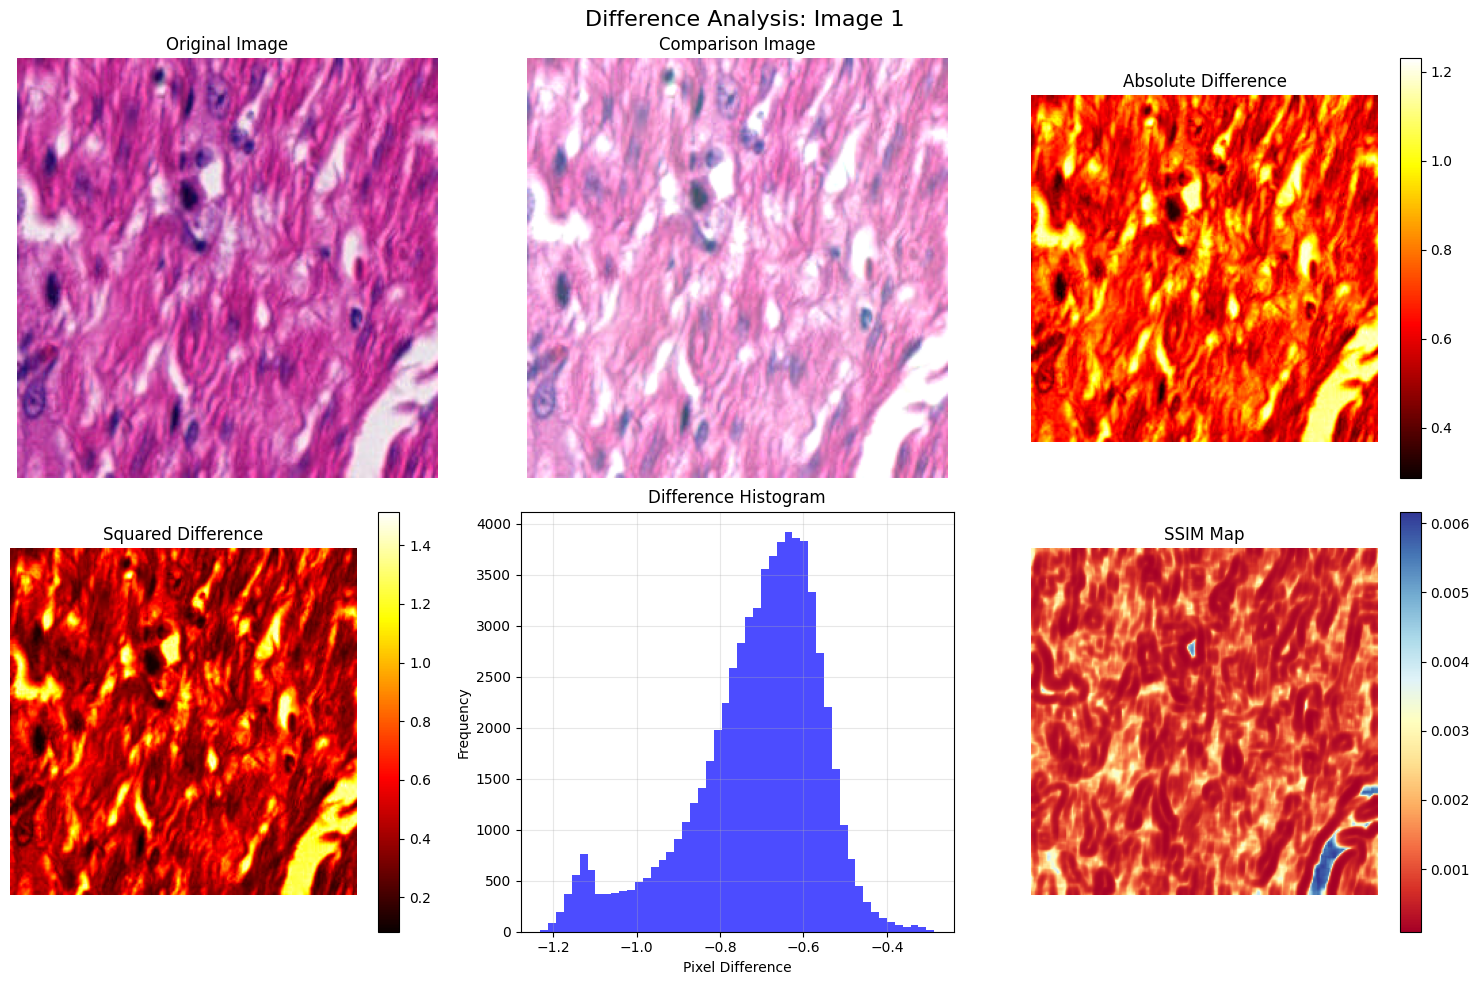

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.12781338322916697..1.3789399718715456].



Processing comparison image 2
SSIM: 0.0009


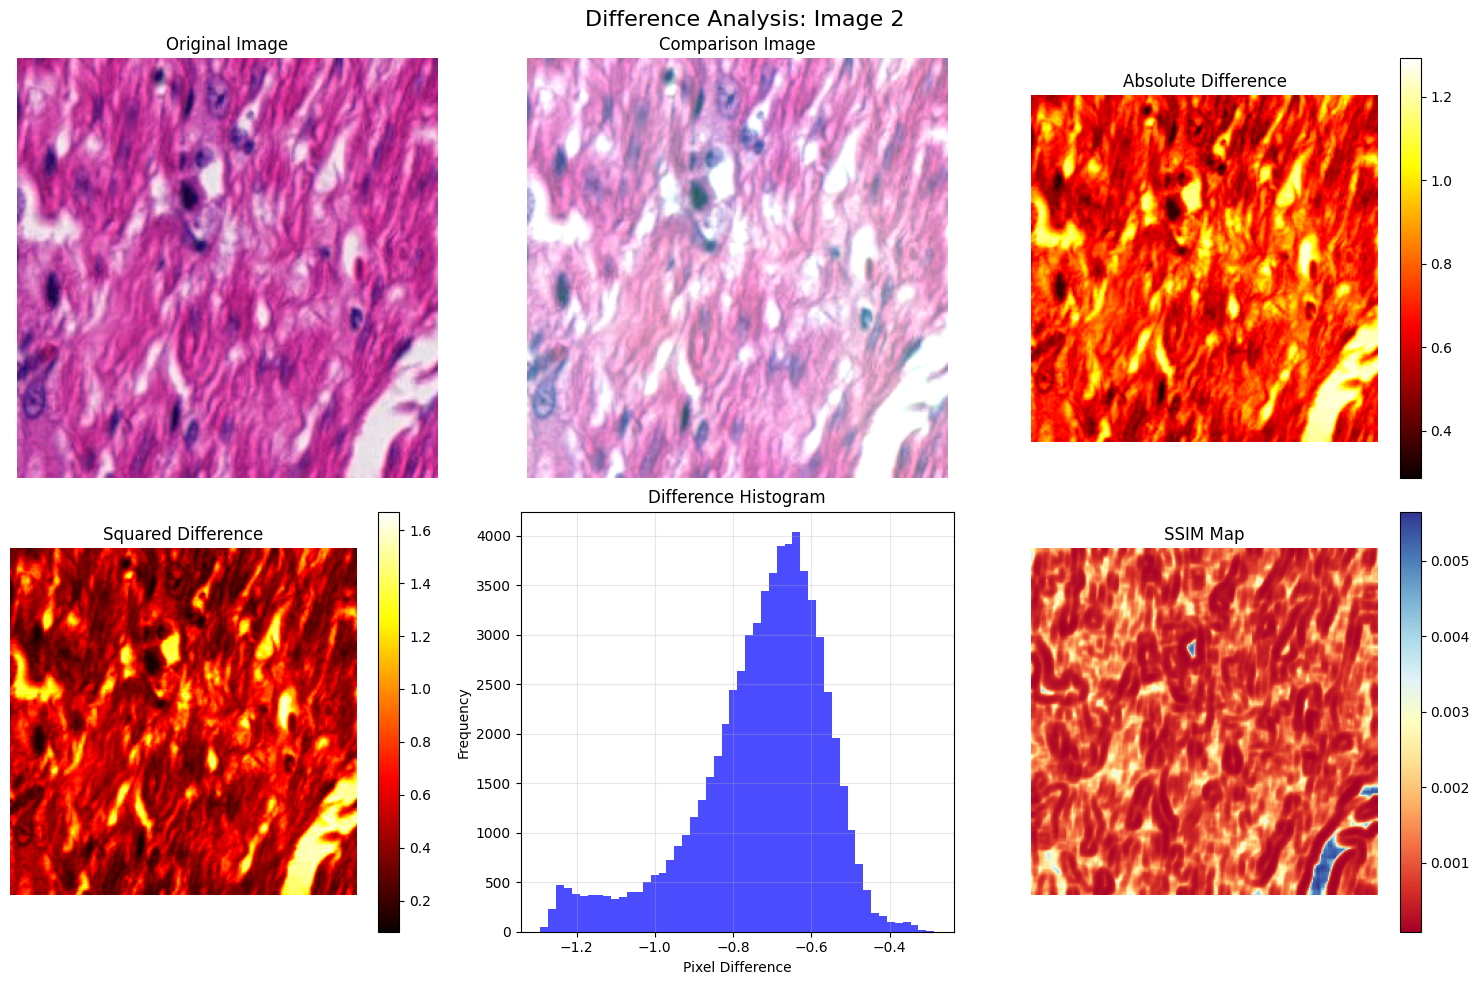

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.11320858425787321..1.292400793325143].



Processing comparison image 3
SSIM: 0.0010


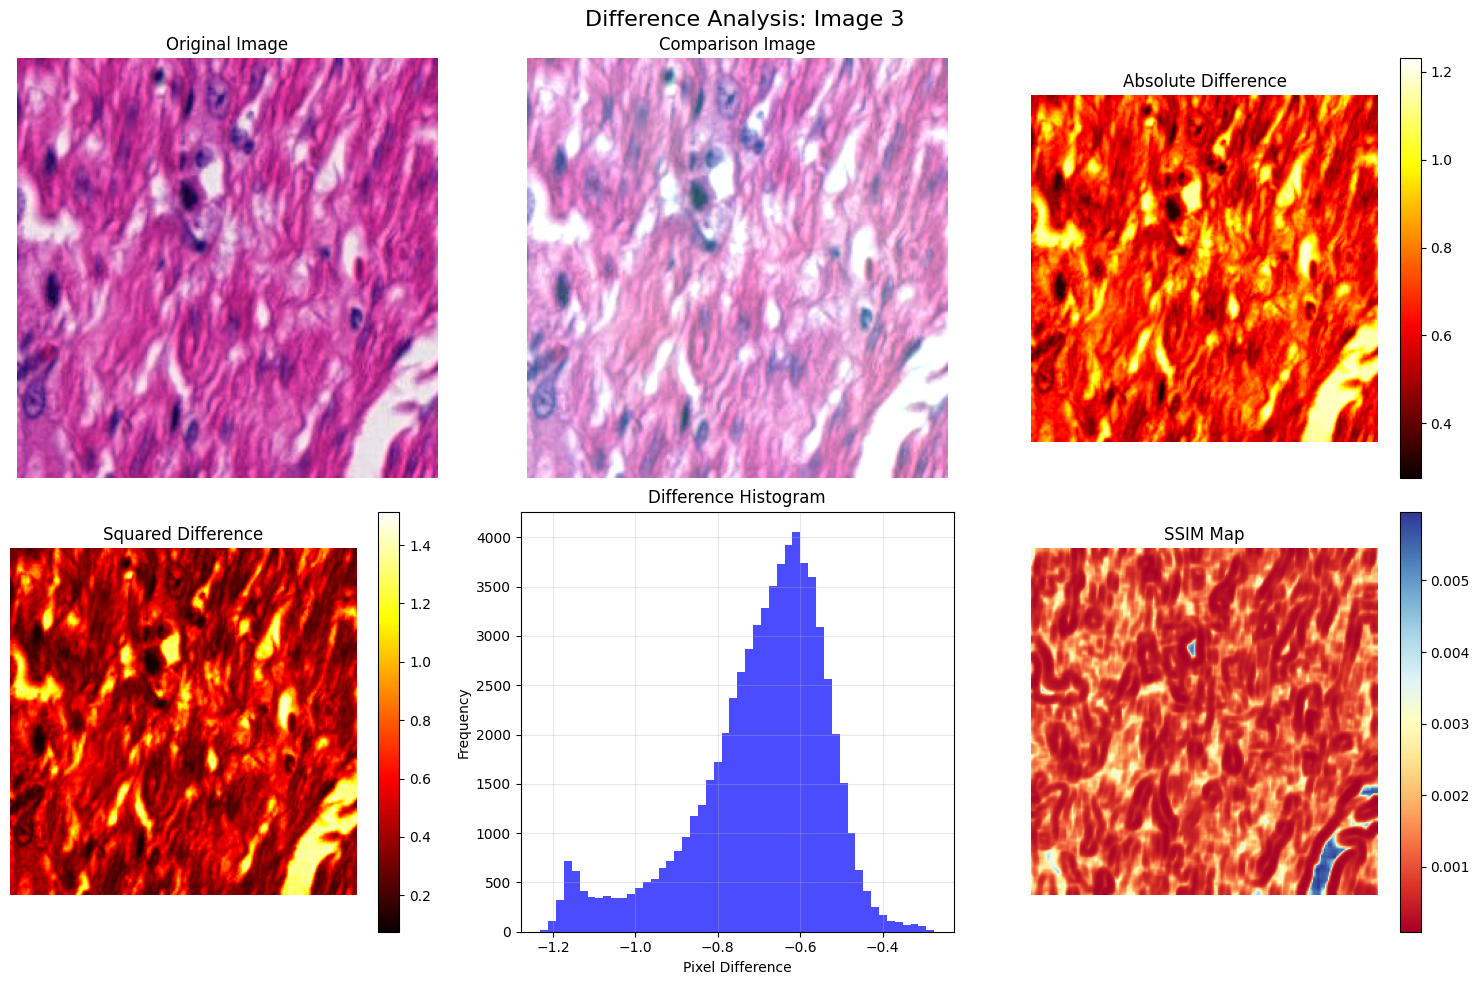

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.11215339479022088..1.2859163571225196].



Processing comparison image 4
SSIM: 0.0010


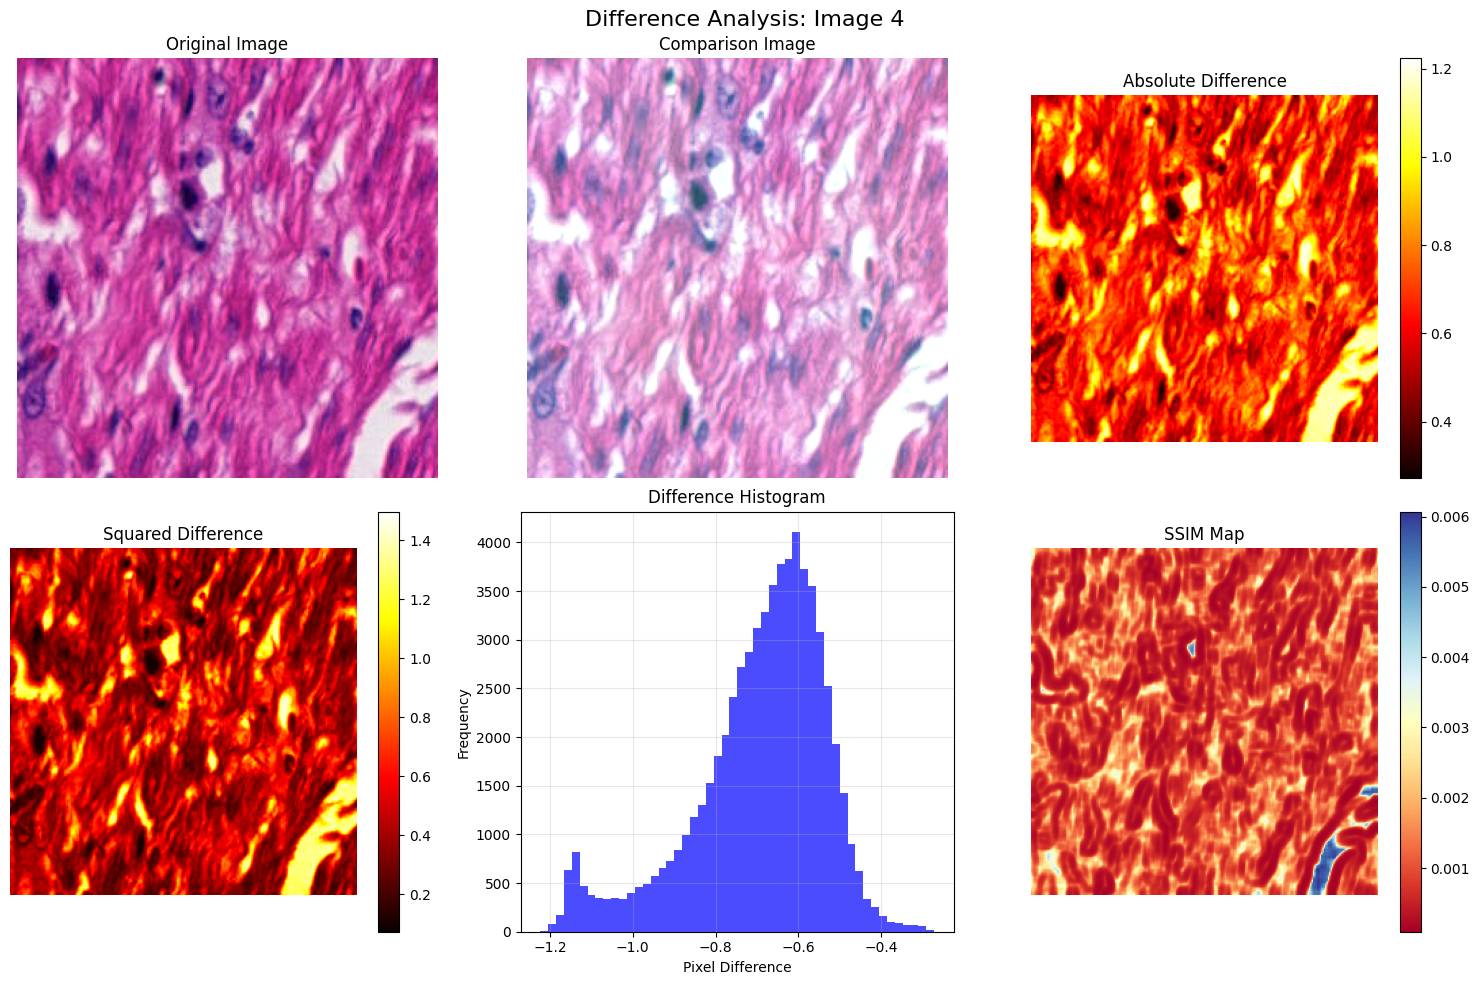

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.10707755368988824..1.196799497562515].



Processing comparison image 5
SSIM: 0.0011


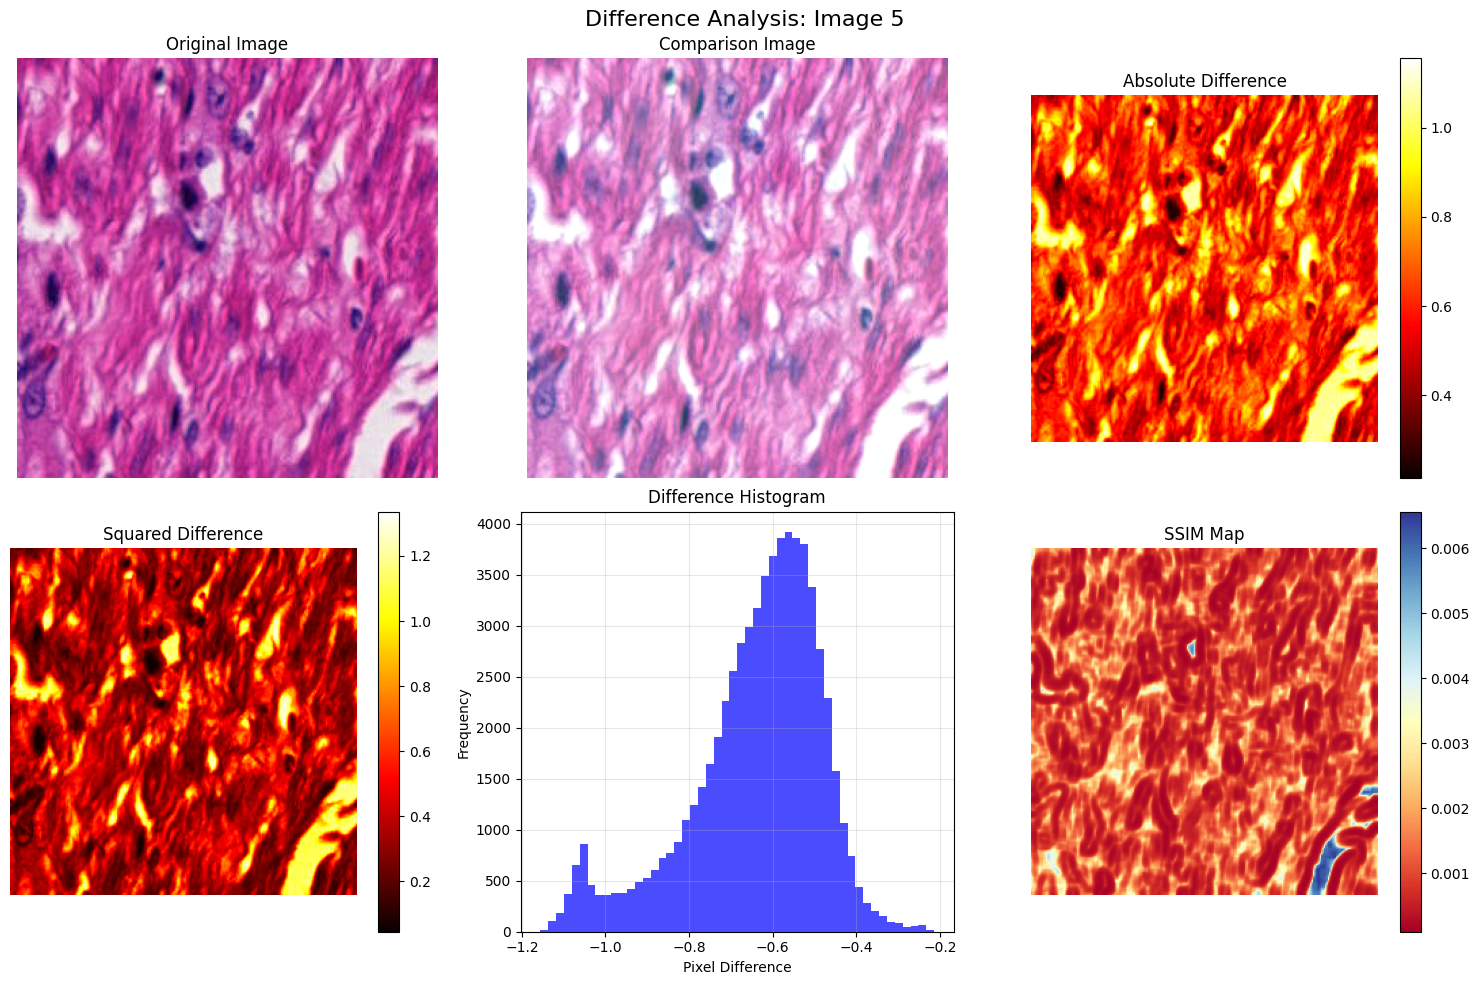

SSIM values: [0.09493298 0.09271092 0.09769848 0.09814212 0.10718567]


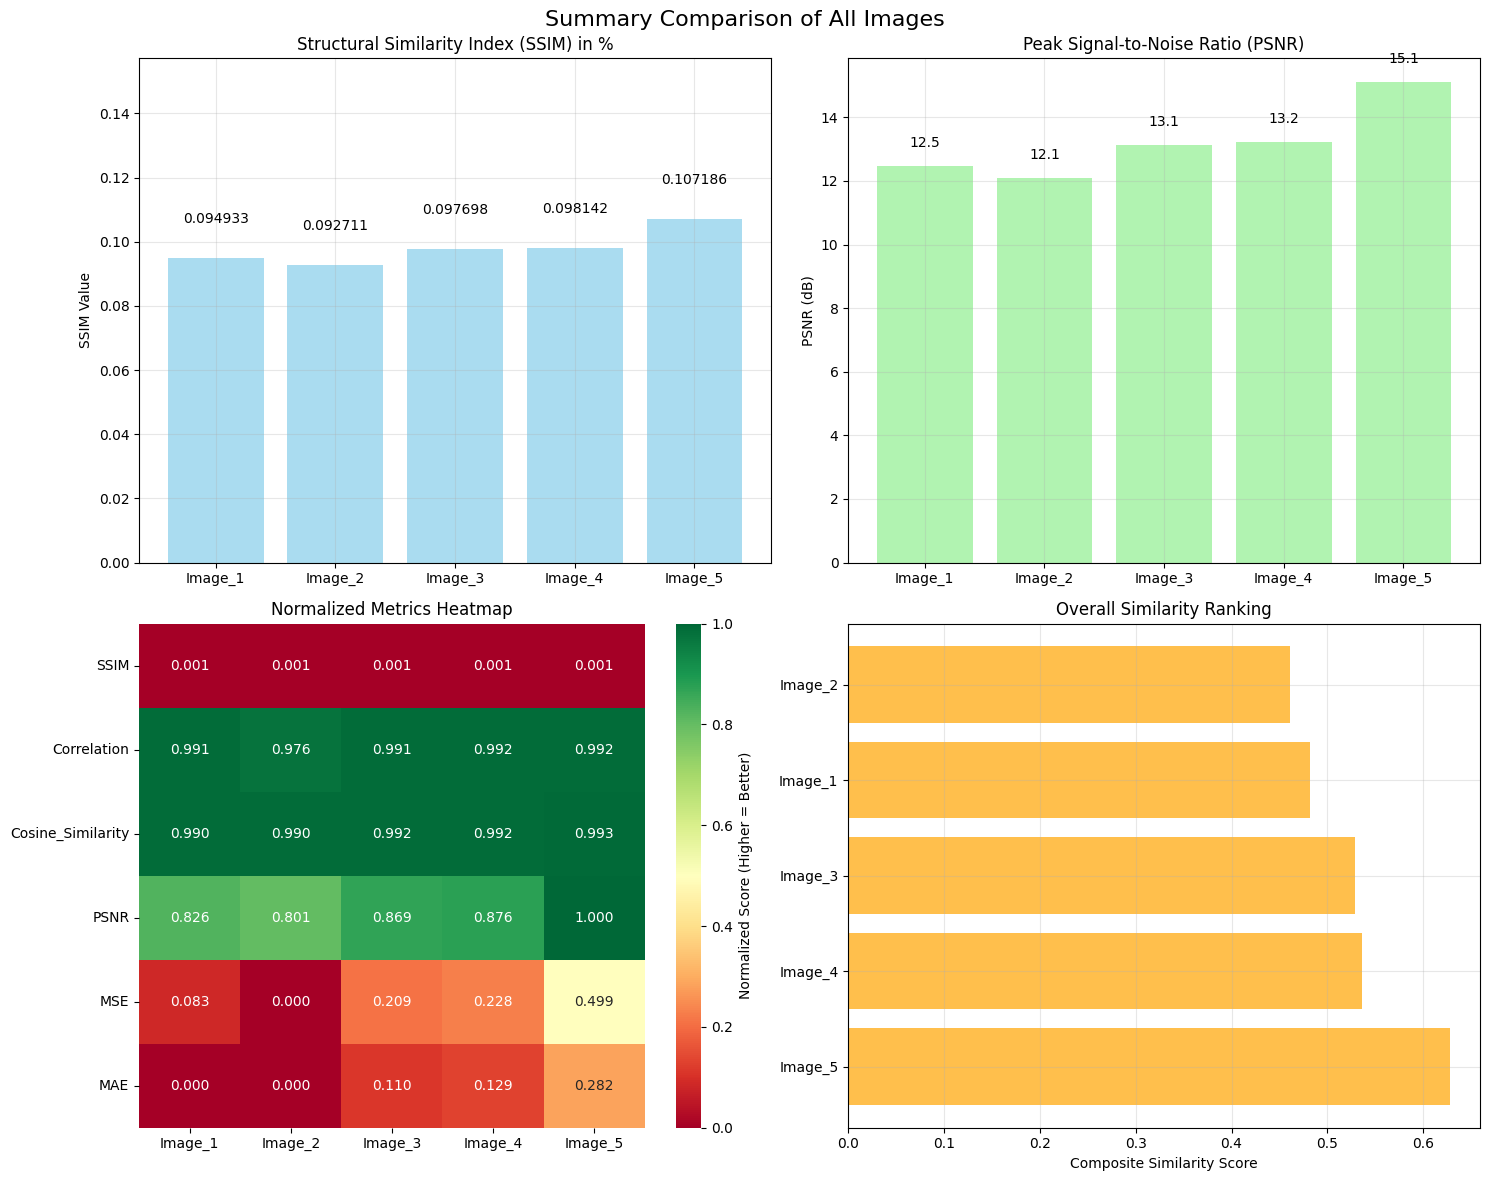


DETAILED SIMILARITY ANALYSIS RESULTS

Image_1:
----------------------------------------
SSIM (Structural Similarity):     0.0009493
PSNR (Peak SNR):                  12.481769 dB
MSE (Mean Squared Error):         0.056471
RMSE (Root Mean Squared Error):   0.237636
MAE (Mean Absolute Error):        0.226513
Correlation:                      0.990623
Cosine Similarity:                0.990000
Histogram Intersection:           10190.000000
Edge SSIM:                        0.000062

Image_2:
----------------------------------------
SSIM (Structural Similarity):     0.0009271
PSNR (Peak SNR):                  12.104187 dB
MSE (Mean Squared Error):         0.061600
RMSE (Root Mean Squared Error):   0.248194
MAE (Mean Absolute Error):        0.226598
Correlation:                      0.976260
Cosine Similarity:                0.990195
Histogram Intersection:           10027.000000
Edge SSIM:                        0.000061

Image_3:
----------------------------------------
SSIM (Structural 

In [62]:
# Definining variables 
dataset_path_KFbio_1 = f"/home/leolr-int/data/data/patched/dim_256/Train/Subset3_Train_1_KFBio"
KFBio_1 = deeplake.open_read_only(dataset_path_KFbio_1)

L_hyperparam = 0.01 #float(input("Enter the L hyperparameter (e.g., 0.1): "))

src_img = KFBio_1[200]["patch"].transpose((2, 1, 0))
KFBio_to_0 = image_to_label(src_img, 0, L_hyperparam).transpose((1, 2, 0))
KFBio_to_1 = image_to_label(src_img, 1, L_hyperparam).transpose((1, 2, 0))
KFBio_to_2 = image_to_label(src_img, 2, L_hyperparam).transpose((1, 2, 0))
KFBio_to_3 = image_to_label(src_img, 3, L_hyperparam).transpose((1, 2, 0))
KFBio_to_4 = image_to_label(src_img, 4, L_hyperparam).transpose((1, 2, 0))


results = analyze_images(src_img.transpose((1,2,0)), [KFBio_to_0, KFBio_to_1, KFBio_to_2, KFBio_to_3, KFBio_to_4], save_results=True)


